In [34]:
import time
import os
import random
#import matplotlib.pyplot as plt; plt.rcdefaults()
from subprocess import Popen, PIPE
import sqlite3
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

In [11]:
#size
B = 1
KB = 1024 * B
MB = 1024 * KB
GB = 1024 * MB
TB = 1024 * GB

#test result
LOG_RES_P50 = "P50"
LOG_RES_P75 = "P75"
LOG_RES_P99 = "P99"
LOG_RES_P999 = "P99.9"
LOG_RES_P9999 = "P99.99"
LOG_RES_MICORS_OP = "micros/op"
LOG_RES_OPS_SEC = "ops/sec"
LOG_RES_RES_LINE = "Result Line"
LOG_RES_DELAY_LINE = "Delay Line"

#test case config
CONFIG_KEY_SIZE = "KeySize"
CONFIG_VALUE_SIZE = "ValueSize"
CONFIG_VM_CACHE_MODE = "VMCacheMode"
CONFIG_TEST_CASE_NAME = "TestCaseName"
CONFIG_ROCKSDB_PARAMETERS = "RocksDB_Parameters"

#dir and file name
PERFORMANCE_RES_DIR_NAME = "performance-testing-log"
PERFORMANCE_RESULT_POSTFIX = "performance-result"

In [12]:

#command line tool
def run_cmd(cmd, throw_exception = False):
    p = Popen(cmd , shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    out_str = out.decode("utf-8")
    err_str = err.decode("utf-8")
    if(throw_exception and err_str != ''):
        raise Exception(err_str)
    return out_str

In [25]:


class Result():
    def __init__(self, res_map = {}):
        self.res_map = res_map
        
    def put_res(self, key, value):
        self.res_map[key] = value
    
    def put_all_res(self, res_map):
        self.res_map.update(res_map)
    

class LogParser():
    def __init__(self, log = None, file_name = None):
        if file_name != None:
            log = open(file_name, 'r').read() 
        self.log = log
        self.lines = log.split("\n")    

    def parse_all(self, res = None):
        self.base_res_line = None
        self.delay_percentiles_line = None
        for line in self.lines:
            self.extract_basic_res_line(line)
            self.extract_delay_percentiles_line(line)
        if res != None:
            res.put_all_res(self.get_basic_res())
            res.put_all_res(self.get_percentiles())

    def extract_basic_res_line(self, line):
        if self.base_res_line == None and "micros/op" in line and "ops/sec" in line:
            self.base_res_line = line

    def extract_delay_percentiles_line(self, line):
        if self.delay_percentiles_line == None and line.startswith("Percentiles: P50"):
            self.delay_percentiles_line = line

    def dump(self):
        print(self.base_res_line)
        print(self.delay_percentiles_line)

    def get_basic_res(self):
        return self.convert_to_dict([LOG_RES_MICORS_OP, LOG_RES_OPS_SEC], self.extract_float(self.base_res_line))

    def get_percentiles(self):
        return self.convert_to_dict([LOG_RES_P50, LOG_RES_P75, LOG_RES_P99, LOG_RES_P999, LOG_RES_P9999],
                                    self.extract_float(self.delay_percentiles_line))

    def extract_float(self, line):
        strs = self.delay_percentiles_line.split(" ")
        res_list = []
        for s in strs:
            if self.is_float(s):
                res_list.append(float(s))
        return res_list

    def convert_to_dict(self, name_list, num_list):
        res_dict = {}
        for i in range(len(name_list)):
            res_dict[name_list[i]] = num_list[i]
        return res_dict

    def is_float(self, s):
        try:
            f = float(s)
            return True
        except:
            return False

In [21]:

class Benchmark():

    def __init__(self, root_dir, db_bench, key_size, value_size, data_size, other_params="",
                 save_res=True, verbose=True):
        self.db_bench = db_bench
        self.key_size = key_size
        self.value_size = value_size
        self.data_size = data_size
        self.other_params = other_params
        self.save_res = save_res
        self.verbose = verbose
        self.test_dir, self.performance_testing_log_dir = self.setup_test_env(root_dir)
        self.num_keys = self.get_num_keys(self.data_size, self.key_size, self.value_size)

    def fillseq(self):
        return self.run_db_bench(benchmarks="fillseq", use_existing_db=False)

    def readseq(self):
        return self.run_db_bench(benchmarks="readseq")

    def overwrite(self):
        return self.run_db_bench(benchmarks="overwrite")

    def readrandom(self):
        return self.run_db_bench(benchmarks="readrandom")

    def readwhilewriting(self):
        return self.run_db_bench(benchmarks="readwhilewriting")

    def deleterandom(self):
        return self.run_db_bench(benchmarks="deleterandom")

    def benchmark_all(self):
        self.fillseq()
        self.readseq()
        self.overwrite()
        self.readrandom()
        self.readwhilewriting()

    def get_num_keys(self, data_size, key_size, value_size):
        return int(data_size / (key_size + value_size))

    def run_db_bench(self, benchmarks, use_existing_db=True, num_keys = -1):
        if num_keys <= 0:
            num_keys = self.get_num_keys(self.data_size, self.key_size, self.value_size)
        const_params = "\
          --db={} \
          --histogram=1 \
          --num={} \
          --use_existing_db={} \
          --key_size={} \
          --value_size={}  \
          --block_size=4096 \
          --compression_type=snappy \
          --max_write_buffer_number=3 \
          --write_buffer_size=33554432 \
          --cache_size=104857600 \
          --statistics {}".format(self.test_dir, num_keys, 1 if use_existing_db else 0, self.key_size, self.value_size,
                                  self.other_params)
        command = "{} --benchmarks=\"{}\"  {} ".format(self.db_bench, benchmarks, const_params)
        if self.verbose:
            print("command : {}".format(command))
        res = run_cmd(command, False)
        if self.save_res == True:
            self.dump_res_to_file(command, res, benchmarks)
        if self.verbose == True:
            print(res)
        return res

    
    def dump_res_to_file(self, command, res, benchmarks):
        file_name = f"{self.performance_testing_log_dir}/{benchmarks}-{PERFORMANCE_RESULT_POSTFIX}"
        if self.verbose:
            print("Dump result to file : {}".format(file_name))
        file = open(file_name, "w+")
        file.write("{}\n\n".format(command))
        file.write(res)
        file.close()

    def setup_test_env(self, root_dir):
        test_dir = self.get_random_test_dir(root_dir)
        performance_testing_log_dir = f"{test_dir}/{PERFORMANCE_RES_DIR_NAME}"
        #if self.verbose:
        print("Setup a new test root. Test root dir {}".format(test_dir))
        self.create_new_dir(test_dir)
        self.create_new_dir(performance_testing_log_dir)
        return test_dir, performance_testing_log_dir

    def create_new_dir(self, dir_name):
        os.system("rm -rf {}".format(dir_name))
        os.system("mkdir {}".format(dir_name))

    def get_random_test_dir(self, root_dir):
        return "{}/test-{}".format(root_dir, random.randint(0, 1000000000))


In [22]:
'''
Benchmark1 : Get/Put latencies for different key/values and different mode (random/sequential/readwhilewrite)

key/value : [10B, 100B], [100B, 1KB], [1KB, 1MB]
'''

def print_log(log):
    parser = LogParser(log)
    parser.parse_all()
    parser.dump()
    
def benchmark1(root, db_bench, data_size):
    
    print("Total Data Size : {}".format(data_size))
    
    total_start = time.time()
    for kv in [[10*B, 100*B], [100*B, 1*KB], [1*KB, 1*MB]]:
        
        benchmark = Benchmark(root_dir = root, db_bench = db_bench, key_size = kv[0], value_size = kv[1],
                       data_size = data_size, other_params = "", save_res=True, verbose=False)
        
        print("Key : {} Value : {} \n".format(kv[0], kv[1]))
        methods = [benchmark.fillseq, benchmark.readseq, benchmark.overwrite, 
                   benchmark.readrandom, benchmark.deleterandom]
        for method in methods:
            start = time.time()
            log = method()
            print_log(log)
            print("time : {}".format(time.time() - start))
            print("\n")
        print("\n\n\n\n")
    print("total time cost : {} seconds".format(time.time() - total_start))


In [26]:
#test parser
parser = LogParser(file_name = "/premium_1t_read_cache/test-48155836/performance-testing-log/readrandom-performance-result")
result = Result()
parser.parse_all(result)
print(result.res_map)

{'micros/op': 9.73, 'ops/sec': 13.02, 'P50': 9.73, 'P75': 13.02, 'P99': 62.64, 'P99.9': 136.33, 'P99.99': 237.97}


In [65]:
def plot_bar_graph(x_label, y_label, title, group_names, group_results, 
                   kv_names = ["Key 10B Value 100B", "Key 100B Value 1KB", "Key 1KB Value 1MB"]):
    #plot the result
        # data to plot
        n_groups = len(kv_names)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8
        
        for i in range(len(group_names)):
            plt.bar(index + bar_width * i, group_results[i], bar_width, alpha=opacity,label=group_names[i])
            
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.xticks(index + bar_width / 2, kv_names)
        plt.legend()

        plt.tight_layout()
        plt.show()



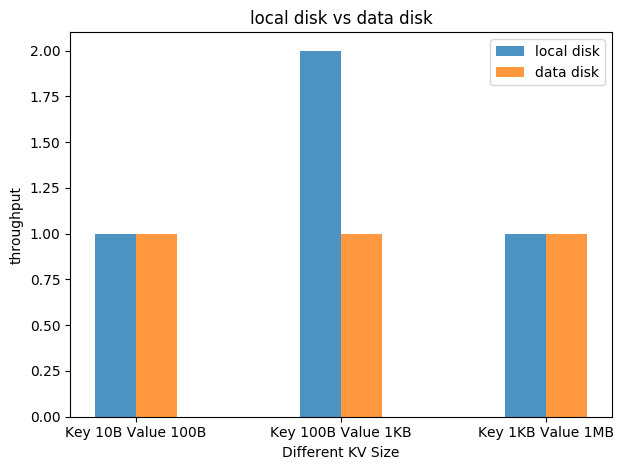

In [66]:
local_disk_fillseq = []
data_disk_fillseq = []


plot_bar_graph(x_label = "Different KV Size", y_label = "Throughput",
               title = "Local disk vs Data disk in Seq ",group_names = ["local disk", "data disk"], 
               group_results = [[1, 2, 1], [1, 1, 1]])



[1, 2, 3]

In [35]:
'''
VM info: 
Type : L4s Storage optimized 
4 CPU 
32GB Memory 
16 Maximum data disk 
5000 IOPS limit
678 GB temp disk
'''
def test_in_L4s_vm_local_disk():
    ROOT = "/mnt/db_data"
    DB_BENCH = "/mnt/rocksdb/db_bench"
    DATA_SIZE = 1 * GB
    benchmark1(ROOT, DB_BENCH, DATA_SIZE)
test_in_L4s_vm_local_disk()

Total Data Size : 1073741824
Setup a new test root. Test root dir /mnt/db_data/test-793354025
Key : 10 Value : 100 

fillseq      :       3.107 micros/op 321852 ops/sec;   33.8 MB/s
Percentiles: P50: 2.31 P75: 2.77 P99: 13.88 P99.9: 29.08 P99.99: 73.84
time : 30.356157541275024


readseq      :       0.316 micros/op 3167003 ops/sec;  332.2 MB/s
Percentiles: P50: 0.52 P75: 0.77 P99: 4.84 P99.9: 14.24 P99.99: 30.68
time : 3.276272773742676


overwrite    :       4.465 micros/op 223954 ops/sec;   23.5 MB/s
Percentiles: P50: 3.44 P75: 3.94 P99: 19.36 P99.9: 36.32 P99.99: 104.58
time : 43.62649965286255


readrandom   :       8.961 micros/op 111597 ops/sec;   11.7 MB/s (9761289 of 9761289 found)
Percentiles: P50: 7.55 P75: 9.82 P99: 41.83 P99.9: 87.14 P99.99: 193.23
time : 87.80661082267761


deleterandom :       4.125 micros/op 242395 ops/sec;
Percentiles: P50: 3.17 P75: 3.75 P99: 18.25 P99.9: 33.42 P99.99: 90.77
time : 40.60285997390747







Setup a new test root. Test root dir /mnt/db_

In [8]:
'''
VM info: 

Type : Standard D4s_v3 General purpose
CPU : 4
Memory : 16GB
Max data disk :8
Max IOPS : 6400
Temp disk size : 32 GB

Data disk size : 1023GB
Data disk IOPS : 5000
Cache: Read only

'''
def test_in_D4s_v3_vm_data_disk():
    ROOT = "/premium_ssd_1t/db_data"
    DB_BENCH = "/premium_ssd_1t/rocksdb/db_bench"
    DATA_SIZE = 1 * GB
    benchmark1(ROOT, DB_BENCH, DATA_SIZE)
#test_in_D4s_v3_vm_data_disk()

Total Data Size : 1073741824
Setup a new test root. Test root dir /premium_ssd_1t/db_data/test-648611266
Key : 10 Value : 100 

fillseq      :       3.305 micros/op 302550 ops/sec;   31.7 MB/s
Percentiles: P50: 2.25 P75: 2.74 P99: 17.61 P99.9: 47.76 P99.99: 100.57
time : 32.36645197868347


readseq      :       0.314 micros/op 3182820 ops/sec;  333.9 MB/s
Percentiles: P50: 0.52 P75: 0.77 P99: 4.86 P99.9: 17.10 P99.99: 46.82
time : 3.4180593490600586


overwrite    :       5.528 micros/op 180882 ops/sec;   19.0 MB/s
Percentiles: P50: 3.52 P75: 4.41 P99: 21.44 P99.9: 67.97 P99.99: 1161.17
time : 54.032819986343384


readrandom   :       8.658 micros/op 115503 ops/sec;   12.1 MB/s (9761289 of 9761289 found)
Percentiles: P50: 6.60 P75: 8.54 P99: 71.49 P99.9: 143.12 P99.99: 213.25
time : 85.05756568908691


deleterandom :       4.300 micros/op 232547 ops/sec;
Percentiles: P50: 3.25 P75: 3.85 P99: 20.89 P99.9: 58.69 P99.99: 104.31
time : 42.22587323188782







Setup a new test root. Test r

In [10]:
'''
Run again to test warmup latency

'''
#test_in_D4s_v3_vm_data_disk()

Total Data Size : 1073741824
Setup a new test root. Test root dir /premium_ssd_1t/db_data/test-653226617
Key : 10 Value : 100 

fillseq      :       3.247 micros/op 307958 ops/sec;   32.3 MB/s
Percentiles: P50: 2.30 P75: 2.78 P99: 19.00 P99.9: 49.46 P99.99: 95.75
time : 31.80666184425354


readseq      :       0.335 micros/op 2987939 ops/sec;  313.4 MB/s
Percentiles: P50: 0.52 P75: 0.77 P99: 5.15 P99.9: 19.53 P99.99: 47.63
time : 3.5982303619384766


overwrite    :       5.329 micros/op 187634 ops/sec;   19.7 MB/s
Percentiles: P50: 3.56 P75: 4.44 P99: 21.93 P99.9: 67.12 P99.99: 1163.65
time : 52.847405672073364


readrandom   :       8.813 micros/op 113468 ops/sec;   11.9 MB/s (9761289 of 9761289 found)
Percentiles: P50: 6.85 P75: 8.65 P99: 75.82 P99.9: 149.24 P99.99: 238.09
time : 86.55287194252014


deleterandom :       4.439 micros/op 225300 ops/sec;
Percentiles: P50: 3.34 P75: 3.89 P99: 21.05 P99.9: 58.65 P99.99: 106.84
time : 43.4060001373291







Setup a new test root. Test roo

In [9]:
'''
Test data disk with read/write cache



'''
def test_in_D4s_v3_vm_data_disk_readwritecache():
    ROOT = "/premium_ssd_1t_readwrite/db_data"
    DB_BENCH = "/premium_ssd_1t_readwrite/rocksdb/db_bench"
    DATA_SIZE = 1 * GB
    benchmark1(ROOT, DB_BENCH, DATA_SIZE)
#test_in_D4s_v3_vm_data_disk_readwritecache()

Total Data Size : 1073741824
Setup a new test root. Test root dir /premium_ssd_1t_readwrite/db_data/test-298055418
Key : 10 Value : 100 

fillseq      :       3.383 micros/op 295558 ops/sec;   31.0 MB/s
Percentiles: P50: 2.32 P75: 2.78 P99: 18.50 P99.9: 49.02 P99.99: 105.62
time : 34.13412880897522


readseq      :       0.329 micros/op 3036143 ops/sec;  318.5 MB/s
Percentiles: P50: 0.52 P75: 0.77 P99: 4.99 P99.9: 19.77 P99.99: 49.58
time : 3.7021679878234863


overwrite    :       6.231 micros/op 160491 ops/sec;   16.8 MB/s
Percentiles: P50: 3.38 P75: 3.98 P99: 22.19 P99.9: 59.84 P99.99: 109.04
time : 62.84454107284546


readrandom   :       9.771 micros/op 102342 ops/sec;   10.7 MB/s (9761289 of 9761289 found)
Percentiles: P50: 7.17 P75: 8.80 P99: 119.35 P99.9: 223.61 P99.99: 332.19
time : 96.87543058395386


deleterandom :       4.548 micros/op 219890 ops/sec;
Percentiles: P50: 3.43 P75: 3.99 P99: 21.33 P99.9: 62.22 P99.99: 109.18
time : 45.99873995780945







Setup a new test roo

In [7]:
'''

Verify read cache and readwrite cache with 10GB data

'''

def verify_read_vs_readwrite():
    #ROOT = "/premium_ssd_1t_readwrite/db_data"
    disk_locations = ['/premium_1t_read_cache', '/premium_1t_readwrite_cache']
    DB_BENCH = "~/rocksdb/db_bench"
    data_sizes = [10 * GB]
    for size in data_sizes:
        for disk_location in disk_locations:
            print(f"disk_location : {disk_location}, data size : {size}")
            benchmark1(disk_location, DB_BENCH, size)

In [9]:
#verify_read_vs_readwrite()

disk_location : /premium_1t_read_cache, data size : 10737418240
Total Data Size : 10737418240
Setup a new test root. Test root dir /premium_1t_read_cache/test-48155836
Key : 10 Value : 100 

fillseq      :       3.158 micros/op 316664 ops/sec;   33.2 MB/s
Percentiles: P50: 2.19 P75: 2.70 P99: 19.01 P99.9: 49.46 P99.99: 107.32
time : 308.58401012420654


readseq      :       1.000 micros/op 999998 ops/sec;  104.9 MB/s
Percentiles: P50: 0.52 P75: 0.77 P99: 4.58 P99.9: 25.80 P99.99: 625.26
time : 98.38905954360962


overwrite    :      10.538 micros/op 94896 ops/sec;   10.0 MB/s
Percentiles: P50: 3.26 P75: 3.89 P99: 29.86 P99.9: 1217.20 P99.99: 1293.50
time : 1029.1545572280884


readrandom   :      12.017 micros/op 83218 ops/sec;    8.7 MB/s (97612893 of 97612893 found)
Percentiles: P50: 9.73 P75: 13.02 P99: 62.64 P99.9: 136.33 P99.99: 237.97
time : 1173.9400565624237


deleterandom :       4.154 micros/op 240738 ops/sec;
Percentiles: P50: 3.00 P75: 3.65 P99: 20.89 P99.9: 55.28 P99.99: 1